## Assignment 1

**Submission deadlines:** 
- get at least **2** points by Tuesday, 9.03.2021
- remaining points: last lab session before or on Tuesday, 16.03.2021

**Points:** Aim to get 8 out of 12 possible points

## Submission instructions
The class is held remotely. To sumbmit your solutions please show the notebook over the video call. Make sure you know all the questions and asnwers, and that the notebook contains results (before presentation do `Runtime -> Restar and run all`)

We provide starter code, however you are not required to use it as long as you properly solve the tasks.

As always, please submit corrections using GitHub's Pull Requests to https://github.com/janchorowski/dl_uwr.

# Task description

## TLDR
Implement and train a neural network using pure numpy.


## Problem 1 [2p]
Implement a two-layer network, manually set weights and biases to solve the XOR task.

A two-layer neural network implementes a function $f: \mathbb{R}^D \rightarrow \mathbb{R}^O$ where $D$ is the input dimensionality and $O$ is the output dinemsionality. The output goes through an intermediate representation (the hidden layer) with dimensionality $H$. 

The computations are as follows:
\begin{equation}
\begin{split}
A_1 &= x W_1^T + b_1  & \qquad\text{Total input to neurons in the hidden layer (network's first layer)} \\
O_1 &= \sigma_1(A_1)  & \qquad\text{Output of the hidden layer} \\
A_2 &= O_1 W_2^T + b_2 & \qquad\text{Total input to neurons in the output layer (network's second layer)}\\
O_2 &= \sigma_2(A_2) & \qquad\text{Output of the network}
\end{split}
\end{equation}

Where $W$ are weight matrices, $b$ are bias vectors, $\sigma$ are non-linear activation functions (e.g. the logistic sigmoid applied element-wise, or softmax).

For the 2D xor problem the network will:
- have 2 inputs, 2 hidden neurons, one output
- use the logistic sigmoid everywhere (that way we, when hand-designig the weights, we can assume that neurons' outputs are binary).

Therrefore the shapes of the data floing through the network will be:
- input: $x\in\mathbb{}R^{2}$
- hidden layer parameters: $W_1\in\mathbb{}R^{2\times 2}$ and $b_1\in\mathbb{}R^{2}$
- representations in the hidden layer: $A_1\in\mathbb{}R^{2}$ and $O_1\in\mathbb{}R^{2}$
- output layer parameters: $W_2\in\mathbb{}R^{1\times 2}$ and $b_1\in\mathbb{}R^{1}$
- representations in the output layer: $A_2\in\mathbb{}R^{1}$ and $O_2\in\mathbb{}R^{1}$

The network can be seen as a logistic regression model, prefixed by a nonlinear transformation of the data.

The first tasks consists of:
- implementing the network
- selecting parametwrs ($W_1, b_1, W_2, b_2$) such that $f(x)\approx XOR(x_1, x_2)$ where the approximation is die to the sigmoids - the output may be close to 0 or 1, but doesn't need to saturate at 0 or 1.

NB: the convention on weight matrix shapes follows linear [layers in PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html).


## Problem 2 [2p]
1. Add a backward pass.
2. Use a sensible random initialization for weights and biases.
3. Numerically check the correctness of your gradient computation.

There is nice article about taking derivative over vectors and vector chain rule: https://explained.ai/matrix-calculus/ if someone don't have experience with suchr calculus.


## Problem 3 [2p]
1. Implement gradient descent
2. Train your network to solve 3D XOR
3. Try several hidden layer sizes, for each size record the fracton of successful trainings. Then answer:
    - What is the minimal hidden size required to solve 3D XOR (even with low reliability, when the training has to be repeated multiple times)
    - What is the minimal hidden size required to reliably solve 3D XOR
    - Which networks are easier to train - small or large ones? Why?


## Problem 4 [1p]
Replace the first nonlinearity with the [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) activation function. Find a network architecture which reliably learns the 3D XOR problem.


## Problem 5 [1p]
Add a second hidden layer to your network, implement the forward and backward pass, then demonstrate training.


## Problem 6 [2p]
Implement a way to have a _variable number_ of hidden layers. Check how deep sigmoid or ReLU networks you  can train. For simplicity you can assume that all hidden layers have the same number of neurons, and use the same activation function.


## Problem 7 [2p]
For each weight matrix $w\in\mathbb{R}^{n\times m}$, add a randomly initialized `backward weight` $w_b\in\mathbb{R}^{m\times n}$, which will not change during training. Change the backward pass to use $w_b$ instead of $w^T$, getting an approxmatoin of the true gradient. Can you get your network to train?

NB: this approach, dubbed [feedback alignment](https://www.nature.com/articles/ncomms13276), was proposed to make error backpropagation more biologically plausible, by providing a solution to the "weight transport problem". Regular backpropagation requires that neurons not only know their incoming weights (thet they control), but also their outgoing weights (that are controlled by neurons in the upper layers). This is nearly impossible in a real brain.

# Solutions and starter code

In [1]:
import matplotlib.pyplot as plt
import numpy as np

XOR dataset creation

(-0.05985663082437276,
 1.0704965700586295,
 -0.06517660044150111,
 1.065176600441501)

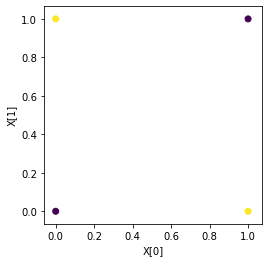

In [2]:
# Let's define a XOR dataset

# X will be matrix of N 2-dimensional inputs
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1],], dtype=np.float32)
# Y is a matrix of N numners - answers
Y = np.array([[0], [1], [1], [0],], dtype=np.float32)

plt.scatter(
    X[:, 0], X[:, 1], c=Y[:, 0],
)
plt.xlabel("X[0]")
plt.ylabel("X[1]")
plt.axis("square")

## Problem 1

The code below contains a mock-up of a two-layer neural network. Fill in the code and manually set weights to solve the XOR problem.

Please note: the shapes are set to be compatible with PyTorch's conventions:
* a batch containing $N$ $D$-dimensional examples has shape $N\times D$ (each example is a row!)
* a weight matrix in a linear layer with $I$ inputs and $O$ outputs has shape $O \times I$
* a bias vector is a 1D vector. Please note that [broadcasting rules](https://docs.scipy.org/doc/numpy/user/basics.broadcasting.html) allow us to think about it as a $1 \times D$ matrix.

In [3]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return x * (x > 0)

class SmallNet:
    def __init__(self, in_features, num_hidden, activation_f_name, dtype=np.float32):
        self.W1 = np.zeros((num_hidden, in_features), dtype=dtype)
        self.b1 = np.zeros((num_hidden,), dtype=dtype)
        self.W2 = np.zeros((1, num_hidden), dtype=dtype)
        self.b2 = np.zeros((1,), dtype=dtype)
        self.activation_f_name = activation_f_name
        self.init_params()

    def init_params(self):
        mu, std = 0, 0.5
        self.W1 = np.random.normal(mu, std, size=(self.W1.shape))
        self.W2 = np.random.normal(mu, std, size=(self.W2.shape))
        self.b1 = np.random.normal(mu, std, size=(self.b1.shape))
        self.b2 = np.random.normal(mu, std, size=(self.b2.shape))
        if self.activation_f_name not in ['relu', 'sigmoid']:
            raise NotImplementedError("No activation function!")

    def forward(self, X, Y=None, do_backward=False):

        # Input to neurons in 1st layer
        A1 = X@self.W1.T + self.b1
        # Outputs after the sigmoid non-linearity
        if self.activation_f_name == 'sigmoid':
            O1 = sigmoid(A1)
        if self.activation_f_name == 'relu':
            O1 = relu(A1)
        # Inputs to neuron in the second layer
        A2 = O1@self.W2.T + self.b2
        # Outputs after the sigmoid non-linearity
        if self.activation_f_name == 'sigmoid':
            O2 = sigmoid(A2)
        if self.activation_f_name == 'relu':
            O2 = relu(A2)

        # When Y is none, simply return the predictions. Else compute the loss
        if Y is not None:
            eps = 1e-9
            loss = -Y * np.log(O2+eps) - (1 - Y) * np.log(1.0 - O2+eps)
            # normalize loss by batch size
            loss = loss.sum() / X.shape[0]
        else:
            loss = np.nan

        if do_backward:
            n, _ = X.shape
            A2_grad = (O2 - Y).T
            self.b2_grad = A2_grad.sum(axis=1) / n
            self.W2_grad = A2_grad@O1 / n
            O1_grad = A2_grad.T@self.W2
            if self.activation_f_name == 'sigmoid':
                A1_grad = O1_grad*O1*(np.ones(O1.shape) - O1) # Sigmoid
            if self.activation_f_name == 'relu':
                A1_grad = O1_grad*(A1 > 0) # Relu
            self.b1_grad = A1_grad.sum(axis=0) / n
            self.W1_grad = (X.T@A1_grad).T / n

        return O2, loss

In [4]:
# TODO Problem 1:
# Set by hand the weight values to solve the XOR problem

net = SmallNet(2, 2, 'sigmoid',dtype=np.float64)
net.W1 = np.array([[20,20],[-20,-20]])
net.b1 = np.array([[-10, 30]])
net.W2 = np.array([[20,20]])
net.b2 = np.array([[-30]])

# Hint: since we use the logistic sigmoid activation, the weights may need to
# be fairly large


predictions, loss = net.forward(X, Y, do_backward=False)
for x, p in zip(X, predictions):
    print(f"XORnet({x}) = {p[0]}")

XORnet([0. 0.]) = 4.543910487654591e-05
XORnet([0. 1.]) = 0.999954519621495
XORnet([1. 0.]) = 0.999954519621495
XORnet([1. 1.]) = 4.543910487654591e-05


## Problem 2

In [5]:
def check_grad(net, param_name, X, Y, eps=1e-5):
    """A gradient checking routine"""

    param = getattr(net, param_name)
    param_flat_accessor = param.reshape(-1)

    grad = np.empty_like(param)
    grad_flat_accessor = grad.reshape(-1)

    net.forward(X, Y, do_backward=True)
    orig_grad = getattr(net, param_name + "_grad")
#     print(param_name)
#     print(param)
#     print(param.shape)
#     print(orig_grad)
#     print(orig_grad.shape)
    assert param.shape == orig_grad.shape

    for i in range(param_flat_accessor.shape[0]):
        orig_val = param_flat_accessor[i]
        param_flat_accessor[i] = orig_val + eps
        _, loss_positive = net.forward(X, Y)
        param_flat_accessor[i] = orig_val - eps
        _, loss_negative = net.forward(X, Y)
        param_flat_accessor[i] = orig_val
        grad_flat_accessor[i] = (loss_positive - loss_negative) / (2 * eps)
    assert np.allclose(grad, orig_grad)
    return grad, orig_grad

In [6]:
# Hint: use float64 for checking the correctness of the gradient
net = SmallNet(2, 2, 'sigmoid', dtype=np.float64)

for param_name in ["W1", "b1", "W2", "b2"]:
    check_grad(net, param_name, X, Y)

## Problem 3

In [7]:
net = SmallNet(2, 10, 'sigmoid', dtype=np.float64)

alpha = 0.1  # set a learning rate

for i in range(100000):
    _, loss = net.forward(X, Y, do_backward=True)
    if (i % 5000) == 0:
        print(f"after {i} steps \tloss={loss}")
    for param_name in ["W1", "b1", "W2", "b2"]:
        param = getattr(net, param_name)
        # Hint: use the construct `param[:]` to change the contents of the array!
        # Doing instead `param = new_val` simply changes to what the variable
        # param points to, without affecting the network!
        # alternatively, you could do setattr(net, param_name, new_value)
        param[:] = param - alpha * getattr(
            net, param_name + "_grad")
#         param[:] = TODO

after 0 steps 	loss=0.7572311461013245
after 5000 steps 	loss=0.039664911806490025
after 10000 steps 	loss=0.010176320069483099
after 15000 steps 	loss=0.005693921073081803
after 20000 steps 	loss=0.003929007455643436
after 25000 steps 	loss=0.0029909517556063214
after 30000 steps 	loss=0.002410475682452366
after 35000 steps 	loss=0.002016406861947632
after 40000 steps 	loss=0.0017316284621279577
after 45000 steps 	loss=0.0015163424088620002
after 50000 steps 	loss=0.0013479534047282015
after 55000 steps 	loss=0.0012126895281591506
after 60000 steps 	loss=0.0011016825576307748
after 65000 steps 	loss=0.0010089658903566525
after 70000 steps 	loss=0.0009303786416119376
after 75000 steps 	loss=0.000862931218346955
after 80000 steps 	loss=0.0008044206380939624
after 85000 steps 	loss=0.000753188012648394
after 90000 steps 	loss=0.0007079604870604346
after 95000 steps 	loss=0.0006677452195971539


In [8]:
predictions, loss = net.forward(X, Y, do_backward=True)
for x, p in zip(X, predictions):
    print(f"XORnet({x}) = {p[0]}")

XORnet([0. 0.]) = 0.00023177282386206978
XORnet([0. 1.]) = 0.9995466267885181
XORnet([1. 0.]) = 0.9991500304893388
XORnet([1. 1.]) = 0.0009909319096957627


In [46]:
# TODO:
# Generate data for a 3D XOR task
# Then estimate the success rate of training the network with diferent
# hidden sizes.

X3 = np.array([[0, 0, 0], [0, 1, 0], [1, 0, 0], [1, 1, 0], [0, 0, 1], [0, 1, 1], [1, 0, 1], [1, 1, 1],], dtype=np.float32)
Y3 = np.array([[0], [1], [1], [0], [1], [0], [0], [1],], dtype=np.float32)

loss_history = [{}, {}]
tmp = -1
for af in ['sigmoid', 'relu']:
    print(af)
    tmp+=1
    for hidden_dim in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 50, 100, 1000, 2000]:
        net = SmallNet(3, hidden_dim, af, dtype=np.float64)
        print('Hidden dim: {}'.format(hidden_dim))
        alpha = 0.1  # set a learning rate

        loss_history[tmp][hidden_dim] = []

        for i in range(10000):
            _, loss = net.forward(X3, Y3, do_backward=True)
            loss_history[tmp][hidden_dim].append(loss)
            for param_name in ["W1", "b1", "W2", "b2"]:
                param = getattr(net, param_name)
                param[:] = param - alpha * getattr(
                    net, param_name + "_grad")

sigmoid
Hidden dim: 1
Hidden dim: 2
Hidden dim: 3
Hidden dim: 4
Hidden dim: 5
Hidden dim: 6
Hidden dim: 7
Hidden dim: 8
Hidden dim: 9
Hidden dim: 10
Hidden dim: 50
Hidden dim: 100
Hidden dim: 1000
Hidden dim: 2000
relu
Hidden dim: 1
Hidden dim: 2
Hidden dim: 3
Hidden dim: 4


<ipython-input-3-1e731028a8b2>:45: RuntimeWarning: invalid value encountered in log
  loss = -Y * np.log(O2+eps) - (1 - Y) * np.log(1.0 - O2+eps)


Hidden dim: 5
Hidden dim: 6
Hidden dim: 7
Hidden dim: 8
Hidden dim: 9
Hidden dim: 10
Hidden dim: 50
Hidden dim: 100
Hidden dim: 1000
Hidden dim: 2000


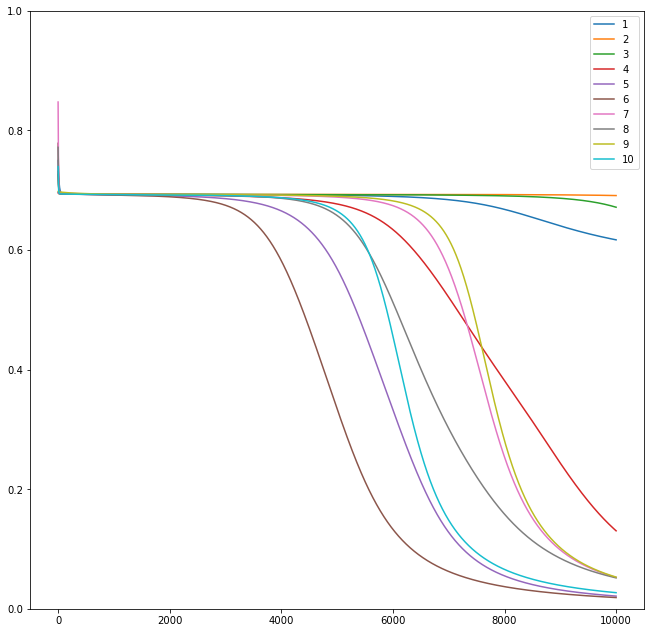

In [10]:
x = np.arange(10000)
plt.figure(figsize = (11,11))
plt.plot(x, loss_history[0][1], label = '1')
plt.plot(x, loss_history[0][2], label = '2')
plt.plot(x, loss_history[0][3], label = '3')
plt.plot(x, loss_history[0][4], label = '4')
plt.plot(x, loss_history[0][5], label = '5')
plt.plot(x, loss_history[0][6], label = '6')
plt.plot(x, loss_history[0][7], label = '7')
plt.plot(x, loss_history[0][8], label = '8')
plt.plot(x, loss_history[0][9], label = '9')
plt.plot(x, loss_history[0][10], label = '10')

plt.legend()
axes = plt.gca()
axes.set_ylim([0,1])
plt.show()

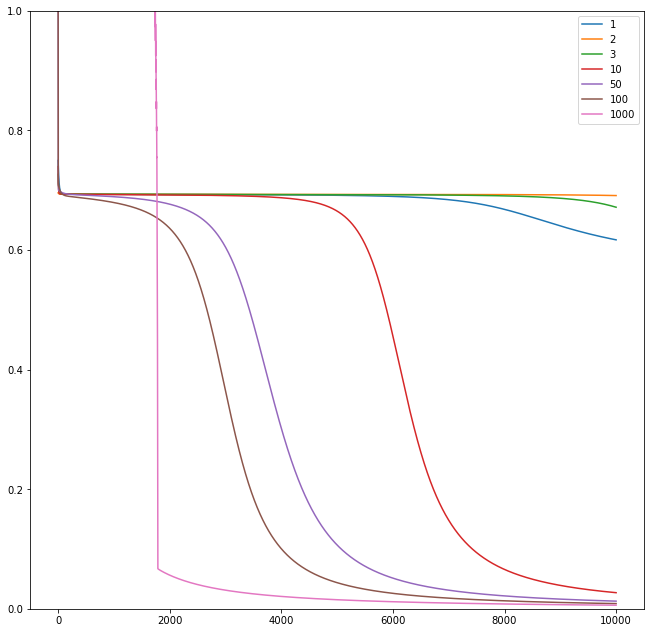

In [11]:
x = np.arange(10000)
plt.figure(figsize = (11,11))
plt.plot(x, loss_history[0][1], label = '1')
plt.plot(x, loss_history[0][2], label = '2')
plt.plot(x, loss_history[0][3], label = '3')
plt.plot(x, loss_history[0][10], label = '10')
plt.plot(x, loss_history[0][50], label = '50')
plt.plot(x, loss_history[0][100], label = '100')
plt.plot(x, loss_history[0][1000], label = '1000')
plt.legend()
axes = plt.gca()
axes.set_ylim([0,1])
plt.show()

    - What is the minimal hidden size required to solve 3D XOR (even with low reliability, when the training has to be repeated multiple times)
    4
    - What is the minimal hidden size required to reliably solve 3D XOR
    100
    - Which networks are easier to train - small or large ones? Why?
    Larger, they are more tunable.

## Problem 4


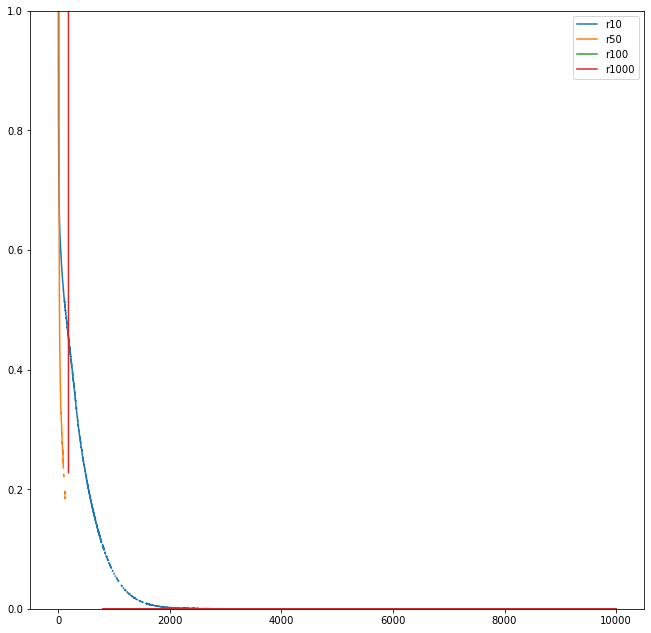

In [12]:
x = np.arange(10000)
plt.figure(figsize = (11,11))
# plt.plot(x, loss_history[0][1], label = 's1')
# plt.plot(x, loss_history[0][2], label = 's2')
# plt.plot(x, loss_history[0][3], label = 's3')
# plt.plot(x, loss_history[0][10], label = 's10')
# plt.plot(x, loss_history[0][50], label = 's50')
# plt.plot(x, loss_history[0][100], label = 's100')
# plt.plot(x, loss_history[0][1000], label = 's1000')
# plt.plot(x, loss_history[1][1], label = 'r1')
# plt.plot(x, loss_history[1][2], label = 'r2')
# plt.plot(x, loss_history[1][3], label = 'r3')
plt.plot(x, loss_history[1][10], label = 'r10')
plt.plot(x, loss_history[1][50], label = 'r50')
plt.plot(x, loss_history[1][100], label = 'r100')
plt.plot(x, loss_history[1][1000], label = 'r1000')
plt.legend()
axes = plt.gca()
axes.set_ylim([0,1])
plt.show()

SmallNet(3, 100, 'relu, dtype=np.float64)

## Problem 6 & 5

In [219]:
def sigmoid(x):
    if x is None:
        return 1
    return 1 / (1 + np.exp(-x))

def relu(x):
    return x * (x > 0)

class BigNet:
    def __init__(self, in_features, num_hidden, num_layers, activation_f_name, dtype=np.float32):
        self.num_layers = num_layers
        self.num_hidden = num_hidden
        
        self.W = [np.zeros((num_hidden, in_features), dtype=dtype)] + [np.zeros((num_hidden, num_hidden), dtype=dtype) for _ in range(num_layers-1)] + [np.zeros((1, num_hidden), dtype=dtype)]
        self.b = [np.zeros((num_hidden,), dtype=dtype)] + [np.zeros((num_hidden,), dtype=dtype) for _ in range(num_layers-1)] + [np.zeros((1,), dtype=dtype)]
        
        self.activation_f_name = activation_f_name
        
        self.init_params()

    def init_params(self):
        mu, std = 0, 0.5
        self.W = [np.random.normal(mu, std, size=(self.W[i].shape)) for i in range(self.num_layers + 1)]
        self.b = [np.random.normal(mu, std, size=(self.b[i].shape)) for i in range(self.num_layers + 1)]
        if self.activation_f_name not in ['relu', 'sigmoid']:
            raise NotImplementedError("No activation function!")

    def forward(self, X, Y=None, do_backward=False):

        Os = [X]
        As = [None]

        for i in range(1, self.num_layers+2):
            A = Os[-1]@self.W[i-1].T + self.b[i-1]
            As.append(A)
            if self.activation_f_name == 'sigmoid':
                Os.append(sigmoid(A))
#             if self.activation_f_name == 'relu':
#                 Os.append(relu(A))
    

        # When Y is none, simply return the predictions. Else compute the loss
        if Y is not None:
            eps = 0.0
            loss = -Y * np.log(Os[-1]+eps) - (1 - Y) * np.log(1.0 - Os[-1]+eps)
            # normalize loss by batch size
            loss = loss.sum() / X.shape[0]
        else:
            loss = np.nan

        if do_backward:
            n, _ = X.shape
            A_grads = [None] * (self.num_layers + 2)
            O_grads = [None] * (self.num_layers + 2)
            self.b_grads = [None] * (self.num_layers + 2)
            self.W_grads = [None] * (self.num_layers + 2)

            A_grads[self.num_layers+1] = (-Y * (1- sigmoid(As[-1])) + (1-Y) * sigmoid(As[-1])) / n
            
            
            for i in range(self.num_layers+1, 0, -1):
                self.b_grads[i] = A_grads[i].sum(0)
                self.W_grads[i] = A_grads[i].T@Os[i-1]
                O_grads[i-1] = A_grads[i]@self.W[i-1]
                if self.activation_f_name == 'sigmoid':
                    A_grads[i-1] = sigmoid(As[i-1]) * (1-sigmoid(As[i-1])) * O_grads[i-1]
#                 if self.activation_f_name == 'relu':
#                     A_grad = O_grad*(inputs[i] > 0) # Relu


        return Os[-1], loss

In [221]:
X3 = np.array([[0, 0, 0], [0, 1, 0], [1, 0, 0], [1, 1, 0], [0, 0, 1], [0, 1, 1], [1, 0, 1], [1, 1, 1],], dtype=np.float32)
Y3 = np.array([[0], [1], [1], [0], [1], [0], [0], [1],], dtype=np.float32)

loss_history = [{}, {}]
tmp = -1
for num_layers in [2,4,6]:
    print('Num hidden layers: {}'.format(num_layers))
    for hidden_dim in [30, 50, 70]:
        net = BigNet(3, hidden_dim, num_layers, 'sigmoid', dtype=np.float64)
        print('Hidden dim: {}'.format(hidden_dim))
        alpha = 0.1  # set a learning rate

        loss_history[tmp][hidden_dim] = []

        for i in range(10000):
            _, loss = net.forward(X3, Y3, do_backward=True)
            loss_history[tmp][hidden_dim].append(loss)
            if (i % 1000) == 0:
                print(f"after {i} steps \tloss={loss}")
            for i in range(0, net.num_layers + 1):
    #             print(i)
    #             print(net.W[i-1].shape)
    #             print(net.W_grads[i].shape)
                net.W[i] -= alpha * net.W_grads[i+1]

                net.b[i] -= alpha * net.b_grads[i+1]

Num hidden layers: 2
Hidden dim: 30
after 0 steps 	loss=0.7783275095035876
after 1000 steps 	loss=0.6917100963691825
after 2000 steps 	loss=0.68875200551755
after 3000 steps 	loss=0.6754503611036082
after 4000 steps 	loss=0.4880587535853789
after 5000 steps 	loss=0.11058547747574109
after 6000 steps 	loss=0.030486150957800252
after 7000 steps 	loss=0.014146400842778515
after 8000 steps 	loss=0.008493793086729845
after 9000 steps 	loss=0.005840550649008762
Hidden dim: 50
after 0 steps 	loss=2.096473722521987
after 1000 steps 	loss=0.6730519347061812
after 2000 steps 	loss=0.35764644606471163
after 3000 steps 	loss=0.11496762021337487
after 4000 steps 	loss=0.04870111802322342
after 5000 steps 	loss=0.026632529380133482
after 6000 steps 	loss=0.017110139747424605
after 7000 steps 	loss=0.012144388188782563
after 8000 steps 	loss=0.009203261634702904
after 9000 steps 	loss=0.0073000165930843085
Hidden dim: 70
after 0 steps 	loss=0.7243554073366074
after 1000 steps 	loss=0.6804180752075114